# CEO-Request Challenge

## 1. Problem statement (summarized)

>❓ How should Olist improve its profit margin ❓, given that it has 
> - some revenues per sellers per months
> - some revenues per orders
> - some reputation costs (estimated) per bad reviews
> - some operational costs of IT system that grows with number of orders, but not linearly (scale effects)


Our key findings so far :
- The `wait_time` was the most significant factor behind low review scores, but reading comments of the bad reviews also showed that some of them were linked to the seller or to the product itself.
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`. The latter being outside of Olist's direct control, improving it is not a quick-win recommendation we can make to Olist CEO without in-depth analysis of their operational practices.
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.

### 1.1 **Should Olist remove underperforming sellers from its marketplace ?** 🕵🏻

To analyse the impact of removing the worse sellers from Olist's marketplace, we will perform a what-if analysis: What would have happened if Olist had never accepted these sellers in the first place? (granted, it's hard to know in advance who is a good seller, but let's start with this and iterate later).

1️⃣ Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)
- the number of `orders` (it will impact the overall IT costs)


2️⃣ We will then:
- sort sellers by increasing profits for Olist
- for each number of sellers to remove, compute the financial impact it would have made if they had never been accepted on the platform and find an optimal number of sellers to remove that maximizes Olist's profit margin


In [5]:
### 1.2 : other hypothesis for investigation

# - Should Olist remove the worst performing products / categories from its marketplace entirely?
# - Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
# - Should Olist restrict seller/customer pairs between certain states to avoid delays?
# - Should Olist acquire new sellers, with some cost assumptions to be suggested?
# - ...


## Seller_id computation

In [6]:
from olist.seller import Seller
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def get_review_score():
    
    from olist.data import Olist
    import numpy as np
    import pandas as pd
    
    data = Olist().get_data()

    #filter out only wanted column from dataset
    reviews = data['order_reviews'].filter(items=['order_id','review_score'])
    items = data['order_items'].filter(items=['order_id','seller_id'])

    #left merge on reviews as its the dataframe that has the review scores. Drop null & duplicates for repeated or empty items
    overall = reviews.merge(items, how='left')
    overall.dropna(inplace=True)
    overall.drop_duplicates(inplace=True)

    #create conditional columns for counting afterwards
    overall['cost_of_review'] = overall.review_score.map({
        1: 100,
        2: 50,
        3: 40,
        4: 0,
        5: 0
    })

    #groupby seller_id and agg to get percentage
    answer = overall.groupby(by='seller_id').agg({
        'cost_of_review': 'sum',
        })

    return answer

In [8]:
ans = get_review_score()
ans.head()

,cost_of_review
seller_id,
0015a82c2db000af6aaaf3ae2ecb0532,100
001cca7ae9ae17fb1caed9dfb1094831,3560
001e6ad469a905060d959994f1b41e4f,100
002100f778ceb8431b7a1020ff7ab48f,1110
003554e2dce176b5555353e4f3555ac8,0


In [9]:
ans.shape

(3090, 1)

In [10]:
sellers_info = Seller().get_training_data()
sellers_info.head(3)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.33,0.33,3.00
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.72,0.05,4.55
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.0,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,1.00,0.00,5.00


In [11]:
sellers_info.shape

(2967, 15)

In [12]:
sellers_info = sellers_info.merge(ans, on='seller_id', how = 'inner')

In [13]:
sellers_info.head(3)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score,cost_of_review
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.33,0.33,3.00,140
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.72,0.05,4.55,240
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.0,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,1.00,0.00,5.00,0


In [14]:
sell_cal = sellers_info.copy()
sell_cal['revenues']= sell_cal['sales']*0.1+80*sell_cal['months_on_olist']
sell_cal['IT_cost'] = 500000/sell_cal['n_orders'].sum()*sell_cal['n_orders']
sell_cal['profit']= sell_cal['revenues'] - sell_cal['cost_of_review']-sell_cal['IT_cost']
sell_cal.head(3)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score,cost_of_review,revenues,IT_cost,profit
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.33,0.33,3.00,140,341.870,15.023888,186.846112
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.72,0.05,4.55,240,2290.307,200.318506,1849.988494
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.0,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,1.00,0.00,5.00,0,15.800,5.007963,10.792037


(-6000.0, 100.0)

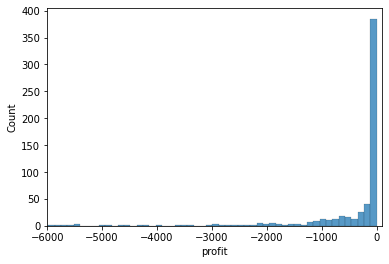

In [15]:
ax = sns.histplot(data=sell_cal[sell_cal['profit']<0], x='profit')
ax.set_xlim(-6000,100)

In [16]:
IT_g = 500000/np.sqrt(sell_cal['n_orders'].sum())
IT_g
#y = IT_g * sqrt(x)

1582.3973364219244

In [17]:
sell_cal.sort_values('profit').filter(items=['seller_id','n_orders','review_score','cost_of_review','revenues','IT_cost','profit'])

,seller_id,n_orders,review_score,cost_of_review,revenues,IT_cost,profit
769,6560211a19b47992c3666cc44a7e94c0,1854,3.94,35290,13770.483,9284.762773,-30804.279773
2358,4a3ca9315b744ce9f8e9374361493884,1806,3.83,39300,21647.292,9044.380565,-26697.088565
1357,cc419e0650a3c5ba77189a1882b7556a,1706,4.07,29300,11948.842,8543.584299,-25894.742299
945,ea8482cd71df3c1969d7b9473ff13abc,1146,4.00,20220,4677.752,5739.125209,-21281.373209
315,8b321bb669392f5163d04c59e235e066,943,4.07,15440,2553.569,4722.508789,-17608.939789
...,...,...,...,...,...,...,...
9,ccc4bbb5f32a6ab2b7066a4130f114e3,187,4.28,2220,8920.462,936.489018,5763.972982
2151,edb1ef5e36e0c8cd84eb3c9b003e486d,166,4.42,1520,8808.455,831.321802,6457.133198
534,fa1c13f2614d7b5c4749cbc52fecda94,585,4.34,6510,21004.203,2929.658156,11564.544844
67,7e93a43ef30c4f03f38b393420bc753a,336,4.21,4700,19323.187,1682.675454,12940.511546


In [18]:
sell_cal.sort_values('profit').tail(-478)['profit'].sum()

1204527.0264543723

In [19]:
sell_cal[sell_cal['profit']<-18].shape

(463, 19)

In [20]:
updated = sell_cal[sell_cal['profit']>=-18].copy()
updated['IT_cost'] = IT_g*np.sqrt(updated['n_orders'].sum())*updated['n_orders']/updated['n_orders'].sum()
updated['profit']= updated['revenues'] - updated['cost_of_review']-updated['IT_cost']
updated.sort_values('profit')

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score,cost_of_review,revenues,IT_cost,profit
2504,4869f7a5dfa277a7dca6462dcf3b52b2,guariba,SP,0.0,15.005261,2017-03-07 13:04:43,2018-08-24 19:55:21,18.0,1132,1156,1.021201,229472.63,0.60,0.11,4.13,17480,24387.263,8209.513859,-1302.250859
71,7299e27ed73d2ad986de7f7c77d919fa,araguari,MG,0.0,11.322033,2017-03-09 11:09:46,2018-08-21 14:30:56,17.0,338,361,1.068047,34725.43,0.68,0.05,4.42,2950,4832.543,2451.250604,-568.707604
1954,54a1852d1b8f10312c55e906355666ee,santa barbara d'oeste,SP,0.0,11.517079,2017-01-13 16:25:19,2018-08-22 10:55:20,19.0,200,204,1.020000,17226.44,0.65,0.08,4.33,2170,3242.644,1450.444145,-377.800145
84,669ae81880e08f269a64487cfb287169,rio do sul,SC,0.0,11.985484,2017-01-21 14:50:18,2018-08-10 03:10:17,19.0,162,186,1.148148,13248.87,0.63,0.10,4.24,2040,2844.887,1174.859757,-369.972757
1744,0241d4d5d36f10f80c644447315af0bd,curitiba,PR,0.0,10.940865,2017-10-10 09:14:14,2018-08-29 03:15:39,11.0,238,246,1.033613,31397.70,0.68,0.08,4.34,2640,4019.770,1726.028532,-346.258532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,ccc4bbb5f32a6ab2b7066a4130f114e3,curitiba,PR,0.0,15.853247,2017-01-07 14:00:13,2018-08-21 21:05:16,19.0,187,192,1.026738,74004.62,0.65,0.09,4.28,2220,8920.462,1356.165275,5344.296725
2151,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,166,175,1.054217,79284.55,0.69,0.07,4.42,1520,8808.455,1203.868640,6084.586360
534,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,585,586,1.001709,194042.03,0.68,0.09,4.34,6510,21004.203,4242.549123,10251.653877
67,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,336,340,1.011905,176431.87,0.63,0.10,4.21,4700,19323.187,2436.746163,12186.440837


In [21]:
print(updated['n_orders'].sum())
print(updated['profit'].sum())
print(sell_cal['profit'].sum())

47609
1097437.034584408
671618.4440000001


In [22]:
sell_cal.sort_values(by='profit').reset_index().drop(columns=['index'])

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score,cost_of_review,revenues,IT_cost,profit
0,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,18.0,1854,2033,1.096548,123304.83,0.51,0.12,3.94,35290,13770.483,9284.762773,-30804.279773
1,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,1806,1987,1.100221,200472.92,0.48,0.14,3.83,39300,21647.292,9044.380565,-26697.088565
2,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,1706,1775,1.040445,104288.42,0.58,0.12,4.07,29300,11948.842,8543.584299,-25894.742299
3,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,1146,1203,1.049738,37177.52,0.53,0.11,4.00,20220,4677.752,5739.125209,-21281.373209
4,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,943,1018,1.079533,17535.69,0.57,0.12,4.07,15440,2553.569,4722.508789,-17608.939789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,ccc4bbb5f32a6ab2b7066a4130f114e3,curitiba,PR,0.0,15.853247,2017-01-07 14:00:13,2018-08-21 21:05:16,19.0,187,192,1.026738,74004.62,0.65,0.09,4.28,2220,8920.462,936.489018,5763.972982
2963,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,166,175,1.054217,79284.55,0.69,0.07,4.42,1520,8808.455,831.321802,6457.133198
2964,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,585,586,1.001709,194042.03,0.68,0.09,4.34,6510,21004.203,2929.658156,11564.544844
2965,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,336,340,1.011905,176431.87,0.63,0.10,4.21,4700,19323.187,1682.675454,12940.511546


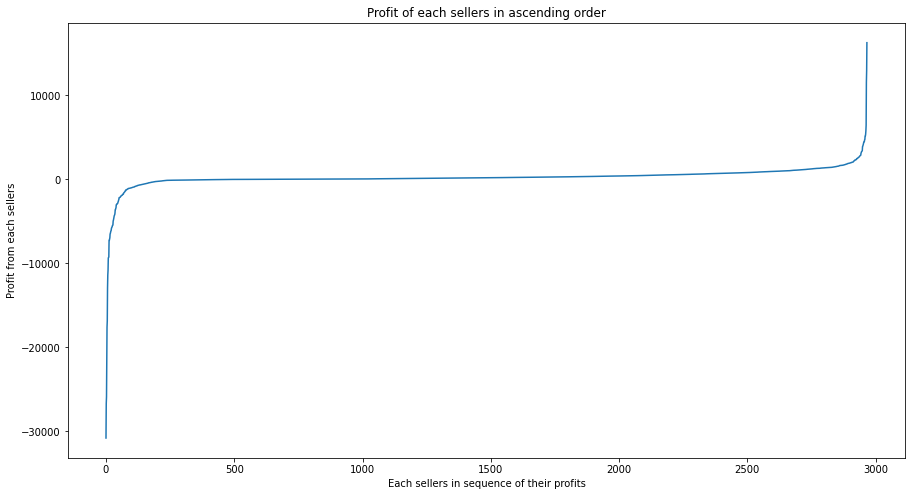

In [23]:
test = sell_cal.sort_values('profit')['profit'].reset_index() #initial graph of seller qty against profit
plt.figure(figsize=(15,8))
plt.plot(test['profit']);
plt.title('Profit of each sellers in ascending order')
plt.xlabel('Each sellers in sequence of their profits')
plt.ylabel('Profit from each sellers');

In [24]:
profitlists = []
it_cost= []
revenues = [] #get maximum profit of filtering sellers
a = -2000
b = 1000

for x in range(a,b,1):
    updated = sell_cal[sell_cal['profit']>=x].copy()
    updated['IT_cost'] = IT_g*np.sqrt(updated['n_orders'].sum())*updated['n_orders']/(updated['n_orders'].sum())
    updated['profit']= updated['revenues'] - updated['cost_of_review']-updated['IT_cost']
    
    profitlists.append(sum(updated['profit']))
    revenues.append(sum(updated['revenues']))
    it_cost.append(sum(updated['IT_cost']))

print(f'maximum profit possible: {max(profitlists)}')
print(f'profit filtered position: {a + profitlists.index(max(profitlists))}')
print(f"sellers removed qty: {sell_cal[sell_cal['profit']<a + profitlists.index(max(profitlists))].shape[0]}")

maximum profit possible: 1097480.79517747
profit filtered position: -15
sellers removed qty: 474


In [25]:
updated = sell_cal[sell_cal['profit']>=-15].copy() #double checking if the index is correct
updated['IT_cost'] = IT_g*np.sqrt(updated['n_orders'].sum())*updated['n_orders']/updated['n_orders'].sum()
updated['profit']= updated['revenues'] - updated['cost_of_review']-updated['IT_cost']
updated['profit'].sum()

1097480.7951774693

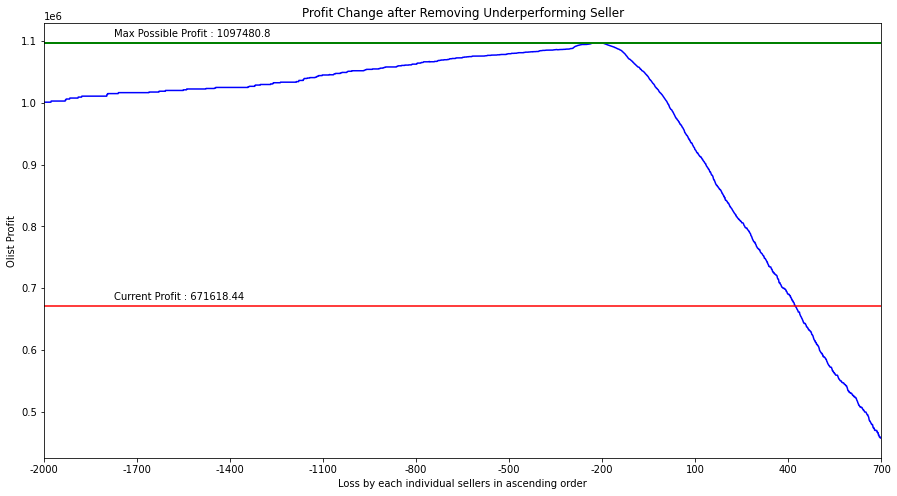

In [35]:
fig, ax = plt.subplots(figsize = (15,8))

plt.title('Profit Change after Removing Underperforming Seller')
ax.plot(profitlists, color='blue', label = 'profit')
ax.axhline(y=max(profitlists), xmin=0, xmax=474, color='green', linewidth = 2, linestyle='-')
ax.axhline(y=sum(sell_cal['profit']), color='red', linestyle='-')
ax.annotate(f'Max Possible Profit : {round(max(profitlists),2)}',xy=(250,max(profitlists)+10000))
ax.annotate(f"Current Profit : {round(sum(sell_cal['profit']),2)}",xy=(250,sum(sell_cal['profit'])+10000))
ax.set_xlabel('Loss by each individual sellers in ascending order')
ax.set_ylabel('Olist Profit')
ax.set_xlim(0, 3000)
plt.xticks(np.linspace(0,3000, 10),np.arange(-2000,1000, 300));


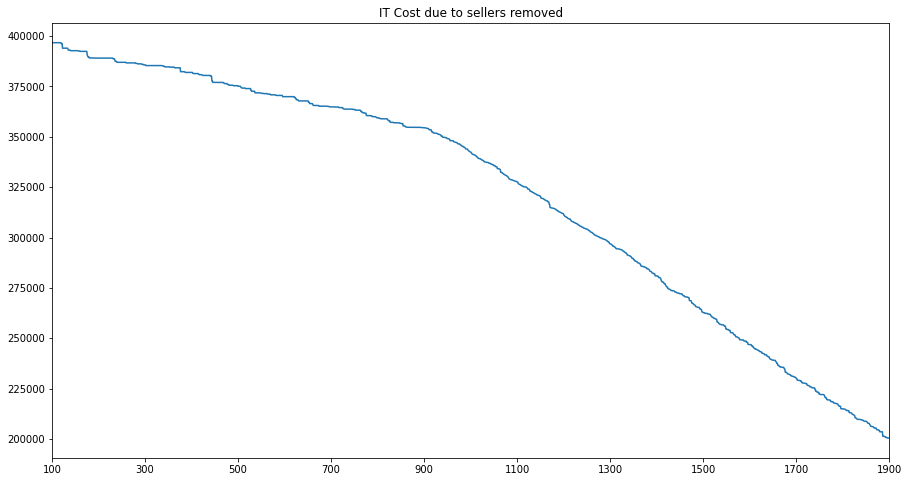

In [23]:
fig, ax = plt.subplots(figsize = (15,8))

plt.title('IT Cost due to sellers removed')
plt.plot(it_cost);
ax.set_xlim(0, 2000)
plt.xticks(np.linspace(0,2000, 10),np.arange(100,2100, 200));

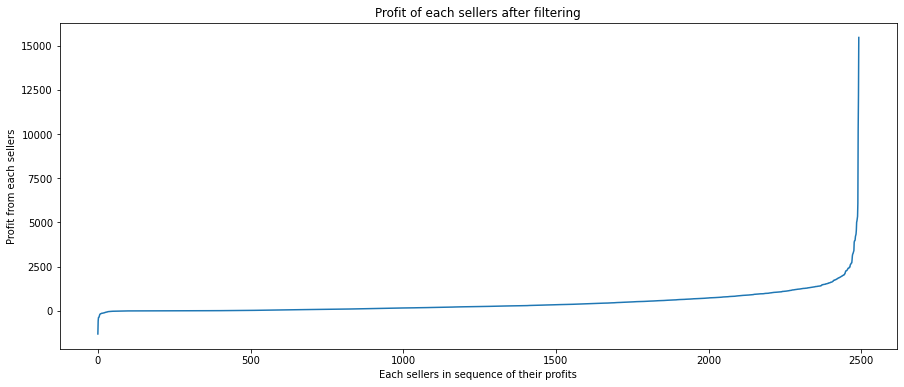

In [26]:
test2 = updated.sort_values('profit')['profit'].reset_index() #after filtering, the seller qty against profit
plt.figure(figsize=(15,6))
plt.plot(test2['profit']);
plt.title('Profit of each sellers after filtering')
plt.xlabel('Each sellers in sequence of their profits')
plt.ylabel('Profit from each sellers');

Group by Products

In [27]:
from olist.data import Olist
import numpy as np
import pandas as pd

data = Olist().get_data()
    
data['order_reviews'].head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


In [28]:
data['order_items'].head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [29]:
data['products'].head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


In [30]:
data['orders'].head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [31]:
data['product_category_name_translation']

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes


In [32]:
def review_score_byprod():
    
    from olist.data import Olist
    import numpy as np
    import pandas as pd
    
    data = Olist().get_data()

    #filter out only wanted column from dataset
    reviews = data['order_reviews'].filter(items=['order_id','review_score'])
    items = data['order_items'].filter(items=['order_id','product_id','price','seller_id'])
    products = data['products'].merge(data['product_category_name_translation'], on ='product_category_name')
    products = products.filter(items=['product_id','product_category_name_english'])
    

    #left merge on reviews as its the dataframe that has the review scores. Drop null & duplicates for repeated or empty items
    overall = reviews.merge(items, how='outer', on = 'order_id')
    overall = overall.merge(products, how='outer', on ='product_id')
    overall.dropna(inplace=True)
    overall.drop_duplicates(inplace=True)

    #create conditional columns for counting afterwards
    overall['cost_of_review'] = overall.review_score.map({
        1: 100,
        2: 50,
        3: 40,
        4: 0,
        5: 0
    })

    #groupby seller_id and agg to get percentage
#     answer = overall.groupby(by=['product_id']).agg({
        
#         'cost_of_review': 'sum',
#         'review_score': lambda x: round(x.mean(),2)})

    return overall

In [33]:
prod = review_score_byprod().filter(items=['product_id','seller_id','product_category_name_english','review_score','price','cost_of_review','cost'])
prod = prod.reset_index().drop(columns=['index'])
prod['cost']= (prod['price']*0.1)-prod['cost_of_review']

prod.sort_values(by='cost')

,product_id,seller_id,product_category_name_english,review_score,price,cost_of_review,cost
41297,8a3254bee785a526d548a81a9bc3c9be,96804ea39d96eb908e7c3afdb671bb9e,construction_tools_construction,1.0,0.85,100,-99.915
62064,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,health_beauty,1.0,1.20,100,-99.880
62063,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,health_beauty,1.0,1.20,100,-99.880
48211,f2d80346f1dd6986e9e6611db7b708aa,94b9108d4b637ba65bb4f1e53cfcf8d8,baby,1.0,3.54,100,-99.646
38266,ba82e510acd9a0fe69a44cafea53f9aa,0e44d110fa6a54e121cb2c095a77762f,stationery,1.0,4.20,100,-99.580
...,...,...,...,...,...,...,...
98597,259037a6a41845e455183f89c5035f18,c72de06d72748d1a0dfb2125be43ba63,computers,5.0,4590.00,0,459.000
93045,c3ed642d592594bb648ff4a04cee2747,59417c56835dd8e2e72f91f809cd4092,small_appliances,4.0,4690.00,0,469.000
78587,a6492cc69376c469ab6f61d8f44de961,59417c56835dd8e2e72f91f809cd4092,small_appliances,5.0,4799.00,0,479.900
79100,1bdf5e6731585cf01aa8169c7028d6ad,ee27a8f15b1dded4d213a468ba4eb391,art,5.0,6499.00,0,649.900


In [34]:
    #groupby seller_id and agg to get percentage
#     answer = overall.groupby(by=['product_id']).agg({
        
#         'cost_of_review': 'sum',
#         'review_score': lambda x: round(x.mean(),2)})

In [35]:
by_product_id = prod.groupby('product_id').agg({
    
    'seller_id':'count',
    'review_score': lambda x: round(x.mean(),2),
    'cost_of_review': 'sum',
    'cost': 'sum'
    
})

In [36]:
by_product_id.sort_values('cost')

,seller_id,review_score,cost_of_review,cost
product_id,,,,
99a4788cb24856965c36a24e339b6058,461,3.90,9180,-5114.884
53759a2ecddad2bb87a079a1f1519f73,286,3.98,5730,-4166.550
7c1bd920dbdf22470b68bde975dd3ccf,227,3.87,5040,-3679.027
422879e10f46682990de24d770e7f83d,352,4.13,5520,-3593.500
e53e557d5a159f5aa2c5e995dfdf244b,153,3.53,4820,-3525.071
...,...,...,...,...
16c4e87b98a9370a9cbc3a4658a3f45b,13,4.31,100,2403.400
5f504b3a1c75b73d6151be81eb05bdc9,63,4.56,330,3443.390
6cdd53843498f92890544667809f1595,150,4.32,1690,3571.670
